# Cells Classification using CNN from scratch
This notebook is dedicated to cell classification using a custom Convolutional Neural Network (CNN). We will explore various network architectures and follow a trial-and-error approach to discover the optimal model for this task.

# Import and Costants

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models
import numpy as np
import pandas as pd
from tensorflow import keras
import os
import shutil
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import imutils
from tqdm import tqdm
from google.colab import drive
from keras.utils import plot_model

# Connection to Google Drive

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%run "/content/drive/MyDrive/Colab Notebooks/B-CellLymphoblastsClassification/Utils.ipynb"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We will also handle the downloading and extraction of the dataset from the Google Drive folder.

In [ ]:
!unzip -q "/content/drive/MyDrive/Colab Notebooks/B-CellLymphoblastsClassification/dataset-split.zip" -d '/'

# Hardware Accelerator test
Initially, it's essential to verify if hardware acceleration is enabled, as training a CNN on a CPU might be impractical.

In [ ]:
#check hardware acceleration
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Dataset loading
Next, we will create Dataset objects from the data stored in the sets directory, utilizing the [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) function provided by Keras.

In [ ]:
train_ds, val_ds, test_ds = load_data_splits(IMAGE_SIZE, BATCH_SIZE)

Found 6396 files belonging to 2 classes.
Found 2132 files belonging to 2 classes.
Found 2133 files belonging to 2 classes.


# One Dense layer with 256 neurons, One Dropout with 0.3
Now, let's define the model that we intend to train.

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

x = data_augmentation_layers(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=5)(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu', name='hidden_classifier') (x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model = compile_model(model, loss="binary_crossentropy")
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                             

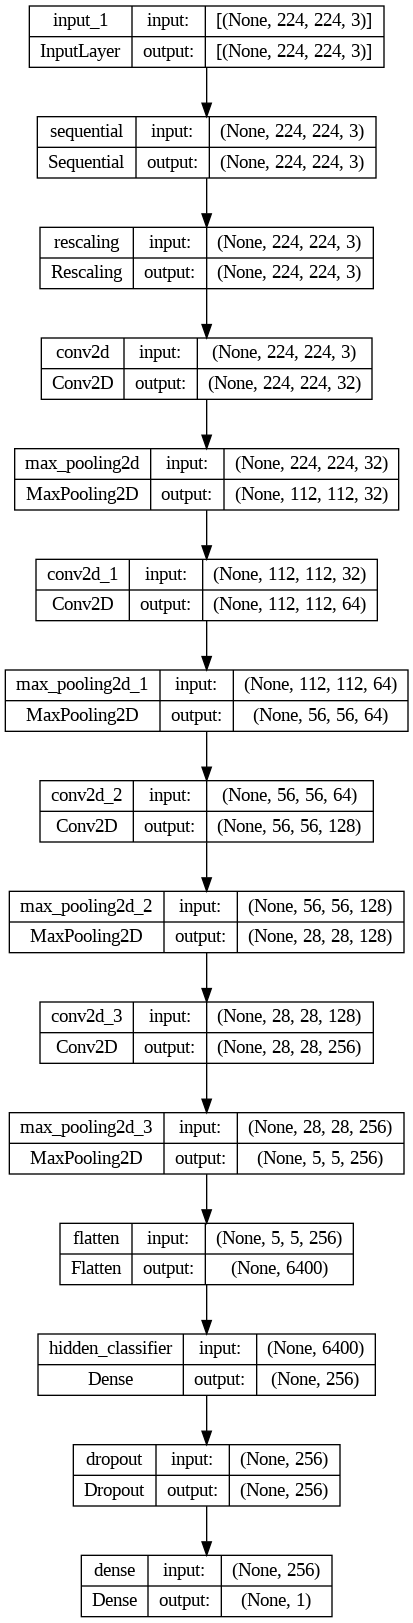

In [ ]:
plot_model(model, show_shapes = True)

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.3548 - accuracy: 0.8430
Epoch 1: val_loss improved from inf to 0.33902, saving model to /content/model/Dense256Neurons_OneDropout0-3.h5
100/100 [==============================] - 19s 165ms/step - loss: 0.3548 - accuracy: 0.8430 - val_loss: 0.3390 - val_accuracy: 0.8626
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - ETA: 0s - loss: 0.3376 - accuracy: 0.8496
Epoch 2: val_loss improved from 0.33902 to 0.31834, saving model to /content/model/Dense256Neurons_OneDropout0-3.h5
100/100 [==============================] - 21s 207ms/step - loss: 0.3376 - accuracy: 0.8496 - val_loss: 0.3183 - val_accuracy: 0.8776
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.3250 - accuracy: 0.8624
Epoch 3: val_loss improved from 0.31834 to 0.31142, saving model to /content/model/Dense256Neurons_OneDropout0-3.h5
100/100 [==============================] - 21s 198ms/step - loss: 0.3250 - accuracy: 0.8624 - val_loss: 0.3114 - val_accuracy: 0.8926
Epoch 4/50
100/100 [==============================] - ETA: 0s - loss: 0.3278 - accuracy: 0.8601
Epoch 4: val_loss improved from 0.31142 to 0.29492, saving model to /content/model/Dense256Neurons_OneDropout0-3.h5
100/100 [==============================] - 19s 185ms/step - loss: 0.3278 - accuracy: 0.8601 - val_loss: 0.2

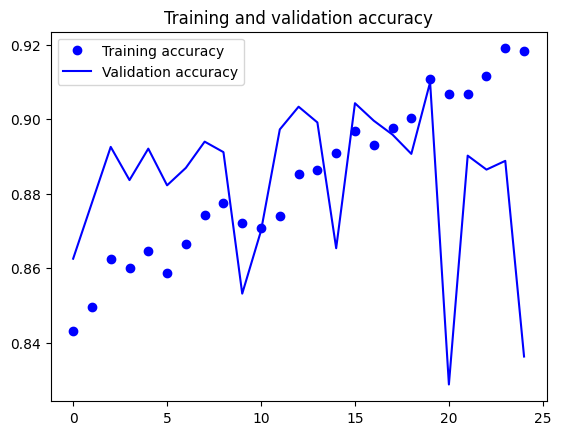

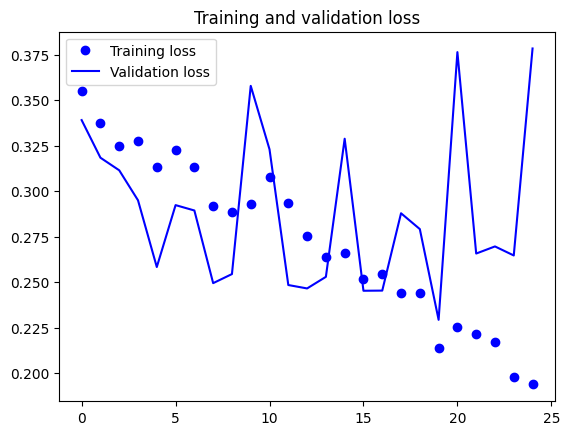

In [ ]:
model, history = run_model(model, "Dense256Neurons_OneDropout0-3", train_ds, val_ds, 50, patience=5, monitor='val_loss')
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, test_ds)

34/34 [==============================] - 4s 114ms/step
Classification report:
              precision    recall  f1-score   support

         all     0.9246    0.9467    0.9355      1463
         hem     0.8772    0.8313    0.8536       670

    accuracy                         0.9105      2133
   macro avg     0.9009    0.8890    0.8946      2133
weighted avg     0.9097    0.9105    0.9098      2133



34/34 [==============================] - 5s 134ms/step


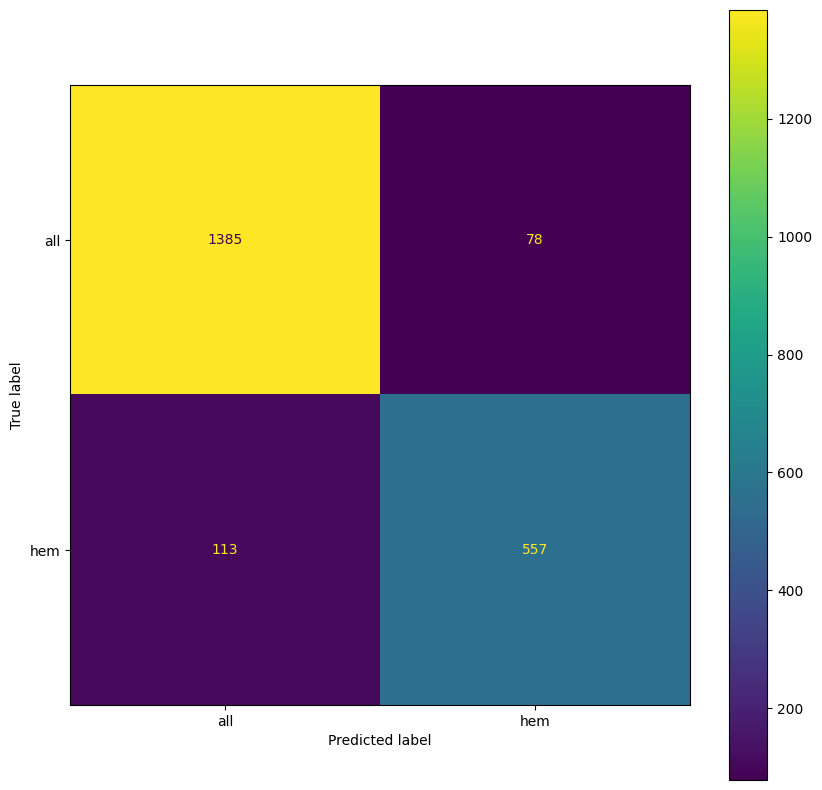

In [ ]:
plot_confusionmatrix(model, test_ds)

# One Dense layer with 128 neurons, One Dropout with 0.3
Now, let's define the model that we intend to train.

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

x = data_augmentation_layers(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=5)(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu', name='hidden_classifier') (x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model = compile_model(model, loss="binary_crossentropy")
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 64)      18496     
                                                           

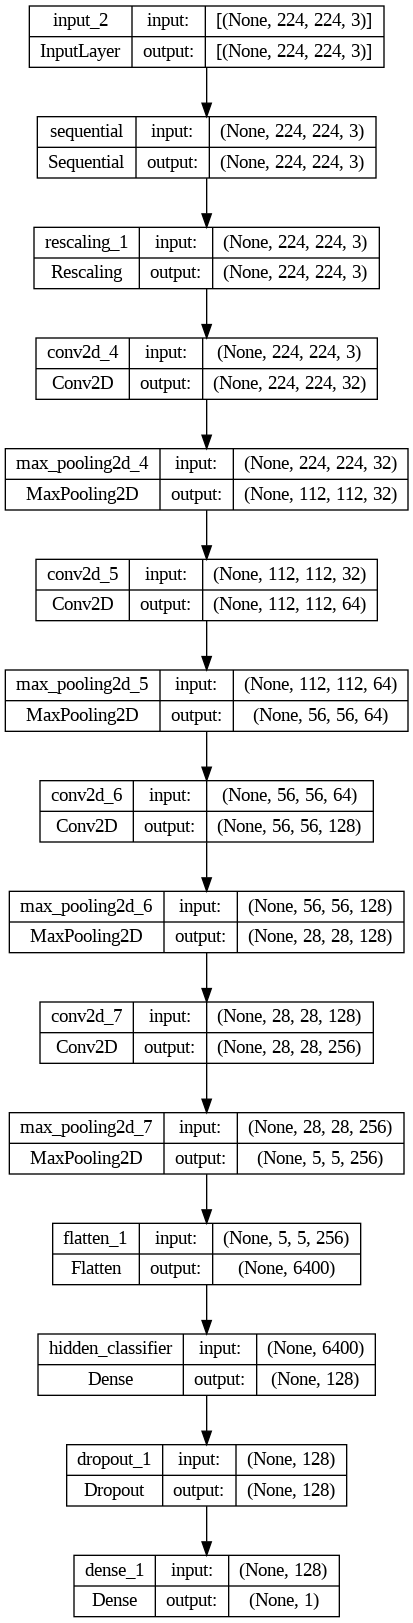

In [ ]:
plot_model(model, show_shapes = True)

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.6805 - accuracy: 0.5660
Epoch 1: val_loss improved from inf to 0.67113, saving model to /content/model/Dense128Neurons_OneDropout0-3.h5
100/100 [==============================] - 22s 190ms/step - loss: 0.6805 - accuracy: 0.5660 - val_loss: 0.6711 - val_accuracy: 0.5863
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - ETA: 0s - loss: 0.6171 - accuracy: 0.6706
Epoch 2: val_loss improved from 0.67113 to 0.56743, saving model to /content/model/Dense128Neurons_OneDropout0-3.h5
100/100 [==============================] - 18s 175ms/step - loss: 0.6171 - accuracy: 0.6706 - val_loss: 0.5674 - val_accuracy: 0.7359
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.5611 - accuracy: 0.7219
Epoch 3: val_loss improved from 0.56743 to 0.48204, saving model to /content/model/Dense128Neurons_OneDropout0-3.h5
100/100 [==============================] - 18s 176ms/step - loss: 0.5611 - accuracy: 0.7219 - val_loss: 0.4820 - val_accuracy: 0.7880
Epoch 4/50
100/100 [==============================] - ETA: 0s - loss: 0.5217 - accuracy: 0.7427
Epoch 4: val_loss did not improve from 0.48204
100/100 [==============================] - 20s 191ms/step - loss: 0.5217 - accuracy: 0.7427 - val_loss: 0.5386 - val_accuracy: 0.7411
Epoch 5/50
100/100 [======================

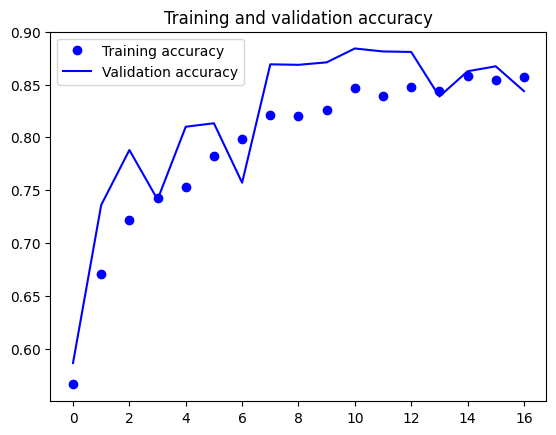

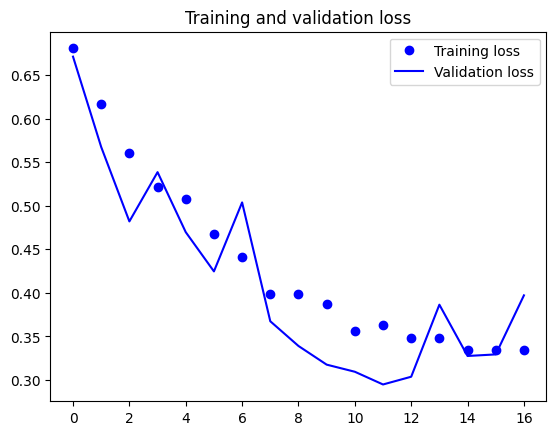

In [ ]:
model, history = run_model(model, "Dense128Neurons_OneDropout0-3", train_ds, val_ds, 50, patience=5, monitor='val_loss')
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, test_ds)

34/34 [==============================] - 4s 108ms/step
Classification report:
              precision    recall  f1-score   support

         all     0.8944    0.9665    0.9290      1463
         hem     0.9112    0.7507    0.8232       670

    accuracy                         0.8987      2133
   macro avg     0.9028    0.8586    0.8761      2133
weighted avg     0.8997    0.8987    0.8958      2133



34/34 [==============================] - 4s 107ms/step


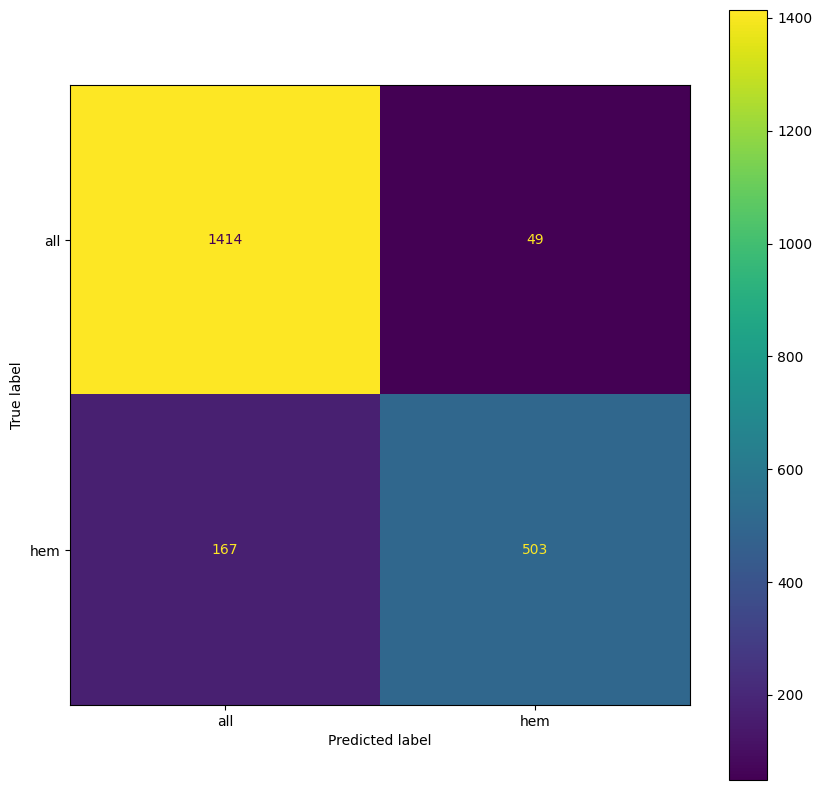

In [ ]:
plot_confusionmatrix(model, test_ds)

# One Dense layer with 512 neurons, One Dropout with 0.3
Now, let's define the model that we intend to train.

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

x = data_augmentation_layers(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=5)(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu', name='hidden_classifier') (x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model = compile_model(model, loss="binary_crossentropy")
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 112, 112, 64)      18496     
                                                           

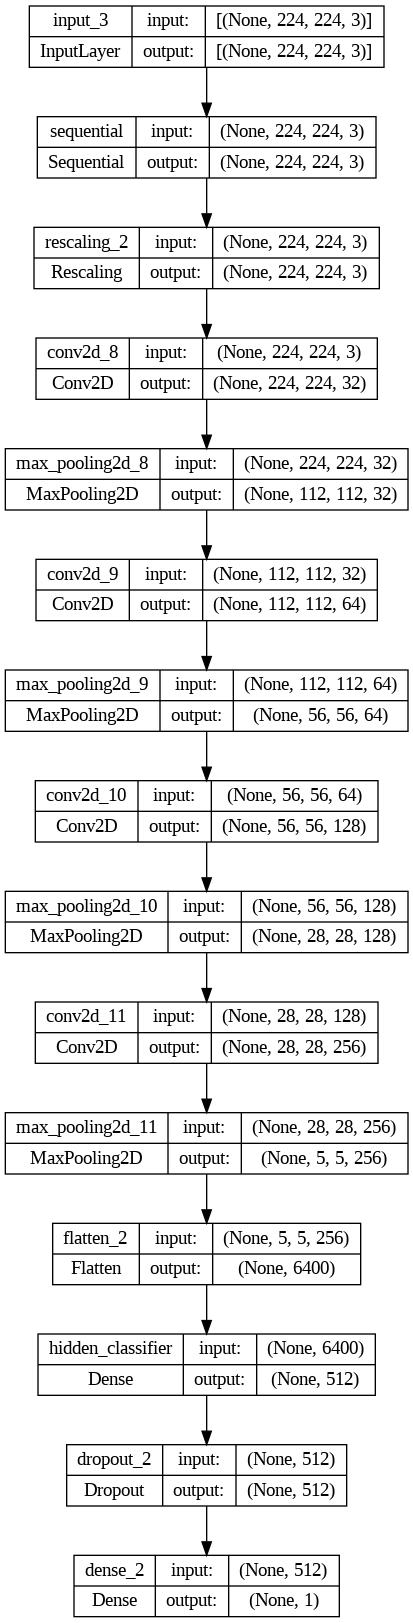

In [ ]:
plot_model(model, show_shapes = True)

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.6797 - accuracy: 0.5574
Epoch 1: val_loss improved from inf to 0.55644, saving model to /content/model/Dense512Neurons_OneDropout0-3.h5
100/100 [==============================] - 21s 179ms/step - loss: 0.6797 - accuracy: 0.5574 - val_loss: 0.5564 - val_accuracy: 0.7392


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 0.6126 - accuracy: 0.6674
Epoch 2: val_loss did not improve from 0.55644
100/100 [==============================] - 19s 179ms/step - loss: 0.6126 - accuracy: 0.6674 - val_loss: 0.5885 - val_accuracy: 0.7134
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.5620 - accuracy: 0.7147
Epoch 3: val_loss improved from 0.55644 to 0.54978, saving model to /content/model/Dense512Neurons_OneDropout0-3.h5
100/100 [==============================] - 18s 176ms/step - loss: 0.5620 - accuracy: 0.7147 - val_loss: 0.5498 - val_accuracy: 0.7439
Epoch 4/50
100/100 [==============================] - ETA: 0s - loss: 0.5200 - accuracy: 0.7500
Epoch 4: val_loss did not improve from 0.54978
100/100 [==============================] - 19s 182ms/step - loss: 0.5200 - accuracy: 0.7500 - val_loss: 0.5787 - val_accuracy: 0.7101
Epoch 5/50
100/100 [==============================] - ETA: 0s - loss: 0.4970 - accuracy: 0.7619
Epoc

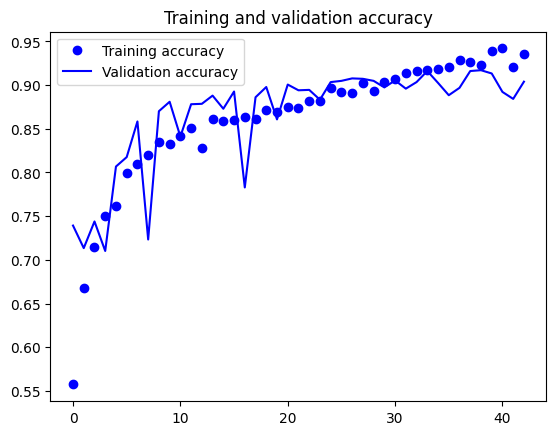

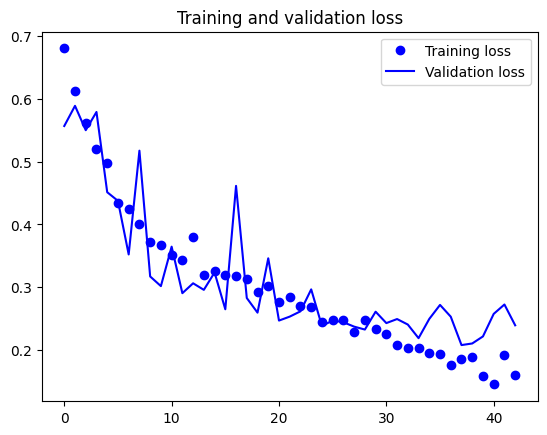

In [ ]:
model, history = run_model(model, "Dense512Neurons_OneDropout0-3", train_ds, val_ds, 50, patience=5, monitor='val_loss')
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, test_ds)

34/34 [==============================] - 4s 126ms/step
Classification report:
              precision    recall  f1-score   support

         all     0.9437    0.9392    0.9414      1463
         hem     0.8685    0.8776    0.8731       670

    accuracy                         0.9198      2133
   macro avg     0.9061    0.9084    0.9072      2133
weighted avg     0.9201    0.9198    0.9199      2133



34/34 [==============================] - 4s 111ms/step


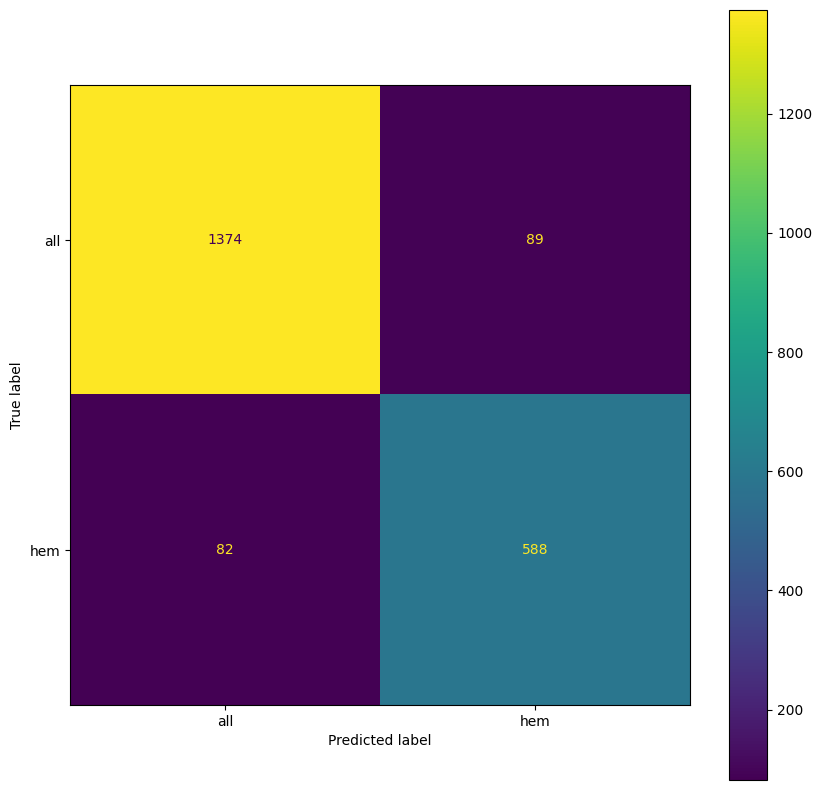

In [ ]:
plot_confusionmatrix(model, test_ds)

# One Dense layer with 512 neurons, One Dropout with 0.5
Now, let's define the model that we intend to train.


In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

x = data_augmentation_layers(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=5)(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu', name='hidden_classifier') (x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model = compile_model(model, loss="binary_crossentropy")
model.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 112, 112, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 112, 112, 64)      18496     
                                                           

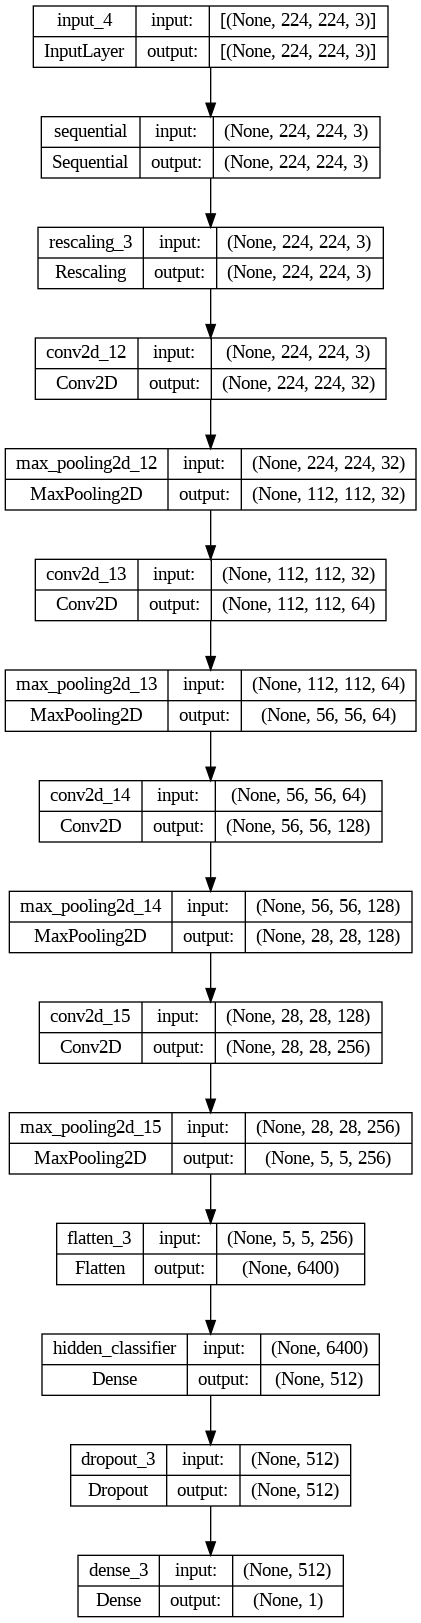

In [ ]:
plot_model(model, show_shapes = True)

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.6816 - accuracy: 0.5561
Epoch 1: val_loss improved from inf to 0.68427, saving model to /content/model/Dense512Neurons_OneDropout0-5.h5
100/100 [==============================] - 23s 194ms/step - loss: 0.6816 - accuracy: 0.5561 - val_loss: 0.6843 - val_accuracy: 0.6731
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - ETA: 0s - loss: 0.6778 - accuracy: 0.5575
Epoch 2: val_loss improved from 0.68427 to 0.67582, saving model to /content/model/Dense512Neurons_OneDropout0-5.h5
100/100 [==============================] - 19s 183ms/step - loss: 0.6778 - accuracy: 0.5575 - val_loss: 0.6758 - val_accuracy: 0.5947
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.5980 - accuracy: 0.6886
Epoch 3: val_loss improved from 0.67582 to 0.58751, saving model to /content/model/Dense512Neurons_OneDropout0-5.h5
100/100 [==============================] - 21s 200ms/step - loss: 0.5980 - accuracy: 0.6886 - val_loss: 0.5875 - val_accuracy: 0.7045
Epoch 4/50
100/100 [==============================] - ETA: 0s - loss: 0.5657 - accuracy: 0.7136
Epoch 4: val_loss improved from 0.58751 to 0.52405, saving model to /content/model/Dense512Neurons_OneDropout0-5.h5
100/100 [==============================] - 19s 181ms/step - loss: 0.5657 - accuracy: 0.7136 - val_loss: 0.5

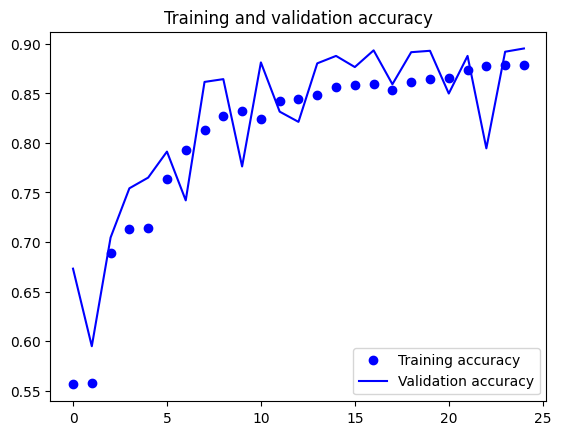

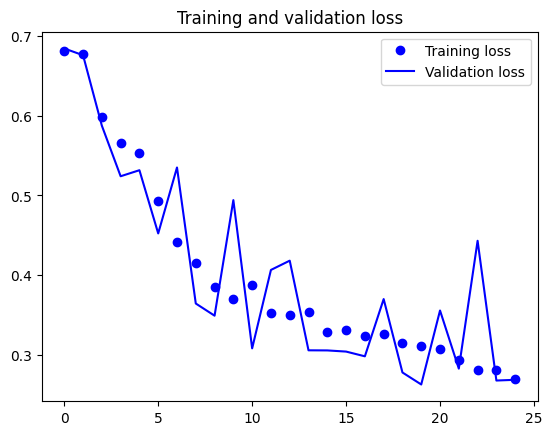

In [ ]:
model, history = run_model(model, "Dense512Neurons_OneDropout0-5", train_ds, val_ds, 50, patience=5, monitor='val_loss')
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, test_ds)

34/34 [==============================] - 5s 139ms/step
Classification report:
              precision    recall  f1-score   support

         all     0.9063    0.9590    0.9319      1463
         hem     0.8974    0.7836    0.8367       670

    accuracy                         0.9039      2133
   macro avg     0.9019    0.8713    0.8843      2133
weighted avg     0.9035    0.9039    0.9020      2133



34/34 [==============================] - 5s 139ms/step


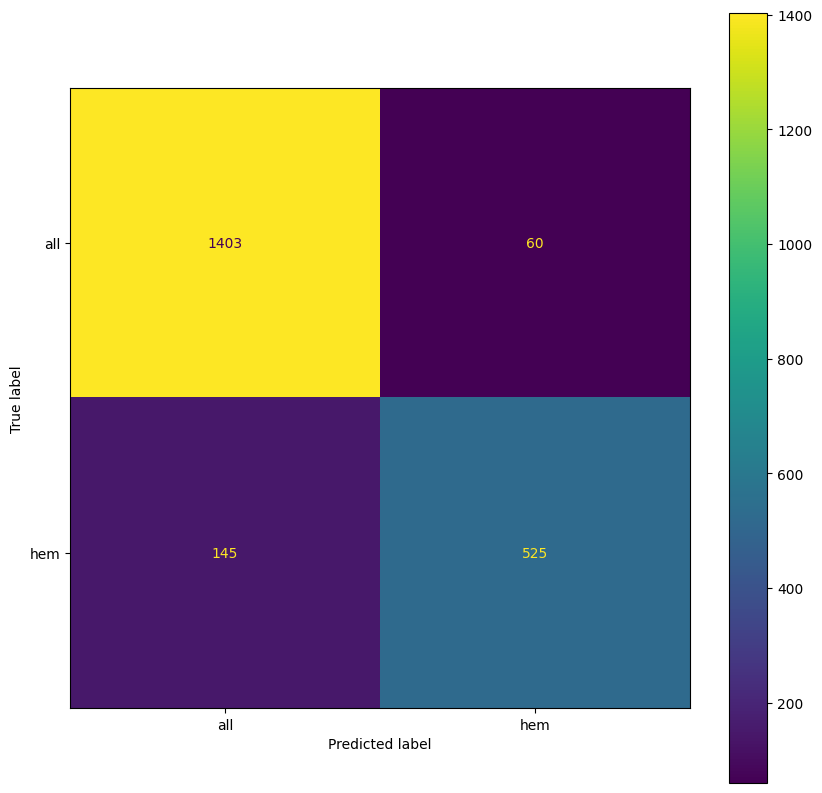

In [ ]:
plot_confusionmatrix(model, test_ds)

# One Conv2D layer with 256 filters, One Dropout with 0.3
Now, let's define the model that we intend to train.

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

x = data_augmentation_layers(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=3)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(filters=256, padding='same', kernel_size=3, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model = compile_model(model, loss="binary_crossentropy")
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 112, 112, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 112, 112, 64)      18496     
                                                           

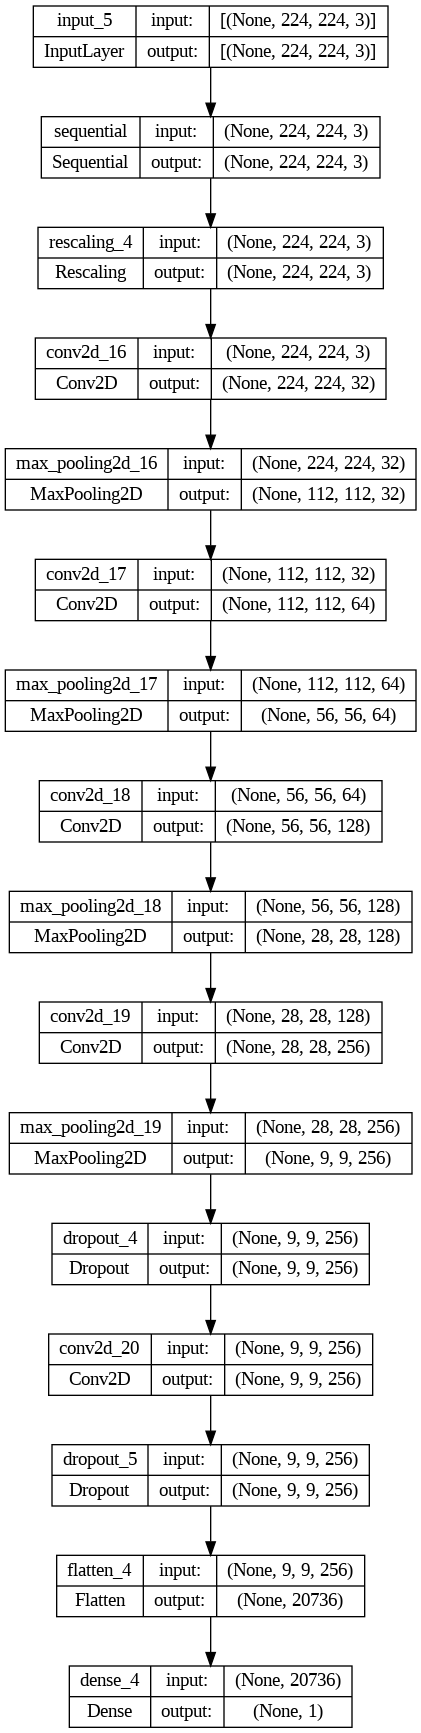

In [ ]:
plot_model(model, show_shapes = True)

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.5056
Epoch 1: val_loss improved from inf to 0.70988, saving model to /content/model/Conv2D256Filters_OneDropout0-3.h5
100/100 [==============================] - 27s 238ms/step - loss: 0.6933 - accuracy: 0.5056 - val_loss: 0.7099 - val_accuracy: 0.3288
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - ETA: 0s - loss: 0.6390 - accuracy: 0.6396
Epoch 2: val_loss improved from 0.70988 to 0.60414, saving model to /content/model/Conv2D256Filters_OneDropout0-3.h5
100/100 [==============================] - 24s 235ms/step - loss: 0.6390 - accuracy: 0.6396 - val_loss: 0.6041 - val_accuracy: 0.7167
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.5863 - accuracy: 0.7003
Epoch 3: val_loss improved from 0.60414 to 0.53515, saving model to /content/model/Conv2D256Filters_OneDropout0-3.h5
100/100 [==============================] - 23s 221ms/step - loss: 0.5863 - accuracy: 0.7003 - val_loss: 0.5351 - val_accuracy: 0.7645
Epoch 4/50
100/100 [==============================] - ETA: 0s - loss: 0.5182 - accuracy: 0.7470
Epoch 4: val_loss improved from 0.53515 to 0.52135, saving model to /content/model/Conv2D256Filters_OneDropout0-3.h5
100/100 [==============================] - 24s 231ms/step - loss: 0.5182 - accuracy: 0.7470 - val_loss: 

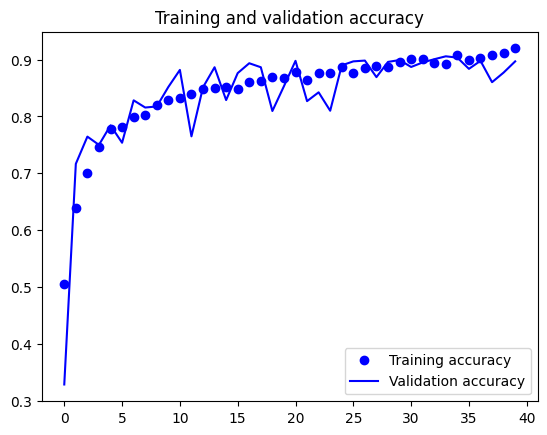

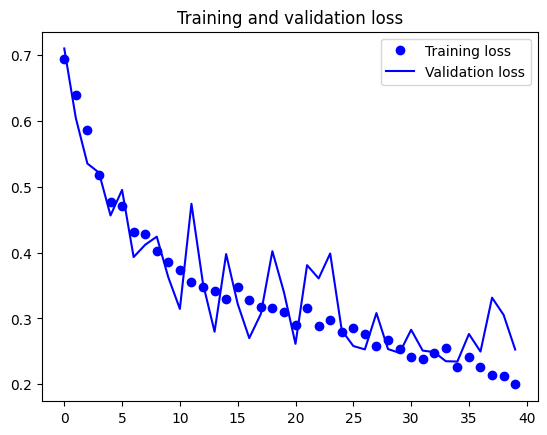

In [ ]:
model, history = run_model(model, "Conv2D256Filters_OneDropout0-3", train_ds, val_ds, 50, patience=5, monitor='val_loss')
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, test_ds)

34/34 [==============================] - 4s 114ms/step
Classification report:
              precision    recall  f1-score   support

         all     0.9302    0.9289    0.9295      1463
         hem     0.8452    0.8478    0.8465       670

    accuracy                         0.9034      2133
   macro avg     0.8877    0.8883    0.8880      2133
weighted avg     0.9035    0.9034    0.9035      2133



34/34 [==============================] - 5s 144ms/step


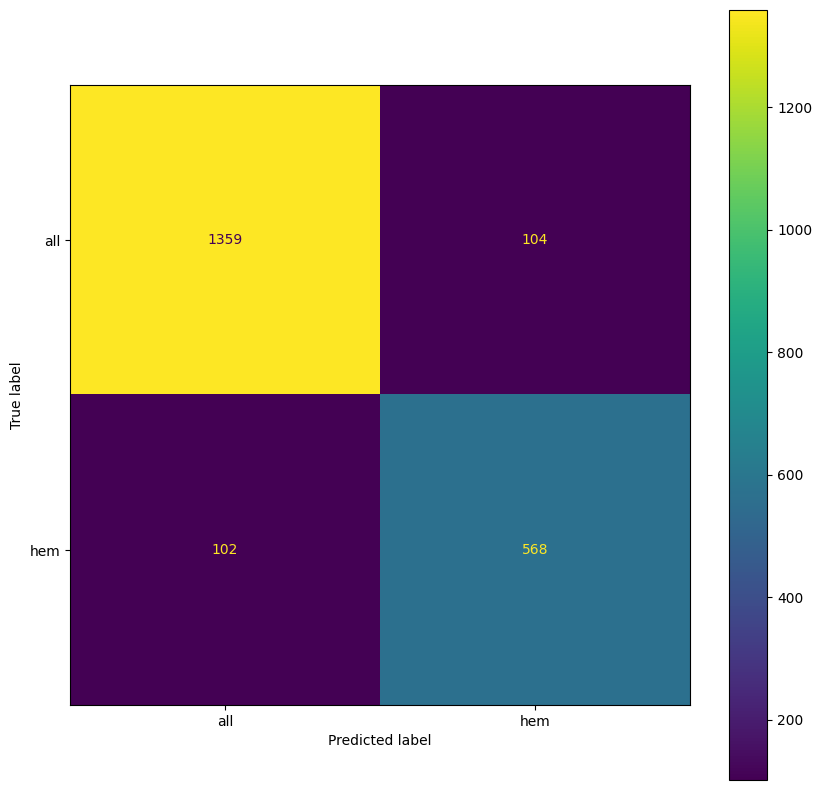

In [ ]:
plot_confusionmatrix(model, test_ds)

# One Conv2D layer with 512 filters, Two Dropouts with 0.3, Additional layer
Now, let's define the model that we intend to train.

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

x = data_augmentation_layers(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=3)(x)
x = layers.Conv2D(filters=512, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=3)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(filters=512, padding='same', kernel_size=3, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model = compile_model(model, loss="binary_crossentropy")
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 112, 112, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 112, 112, 64)      18496     
                                                           

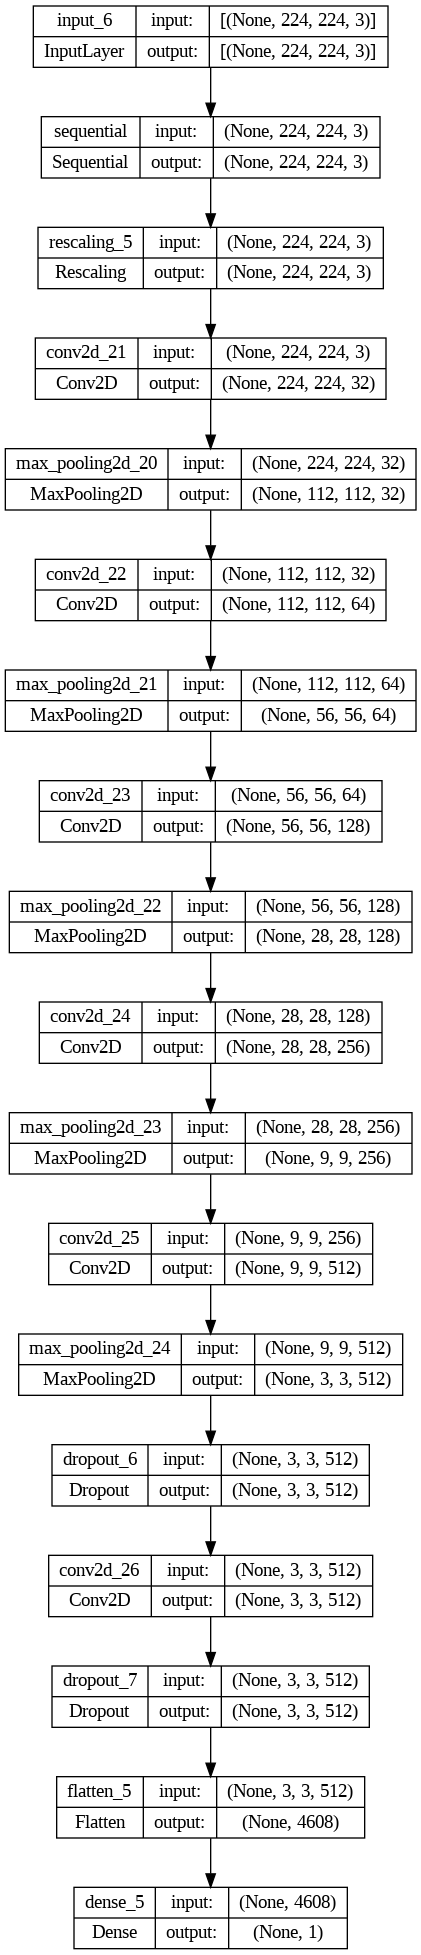

In [ ]:
plot_model(model, show_shapes = True)

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.6832 - accuracy: 0.5632
Epoch 1: val_loss improved from inf to 0.60341, saving model to /content/model/Conv2D512Filters_TwoDropouts0-3.h5
100/100 [==============================] - 45s 266ms/step - loss: 0.6832 - accuracy: 0.5632 - val_loss: 0.6034 - val_accuracy: 0.7026
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - ETA: 0s - loss: 0.6306 - accuracy: 0.6562
Epoch 2: val_loss improved from 0.60341 to 0.54878, saving model to /content/model/Conv2D512Filters_TwoDropouts0-3.h5
100/100 [==============================] - 25s 243ms/step - loss: 0.6306 - accuracy: 0.6562 - val_loss: 0.5488 - val_accuracy: 0.7453
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.5741 - accuracy: 0.7075
Epoch 3: val_loss improved from 0.54878 to 0.47961, saving model to /content/model/Conv2D512Filters_TwoDropouts0-3.h5
100/100 [==============================] - 26s 255ms/step - loss: 0.5741 - accuracy: 0.7075 - val_loss: 0.4796 - val_accuracy: 0.7974
Epoch 4/50
100/100 [==============================] - ETA: 0s - loss: 0.5010 - accuracy: 0.7605
Epoch 4: val_loss improved from 0.47961 to 0.39995, saving model to /content/model/Conv2D512Filters_TwoDropouts0-3.h5
100/100 [==============================] - 25s 237ms/step - loss: 0.5010 - accuracy: 0.7605 - val_los

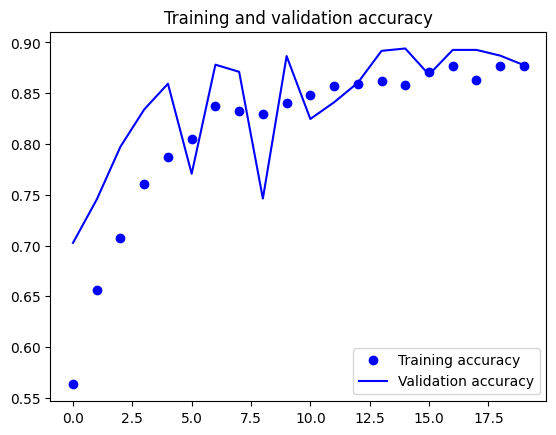

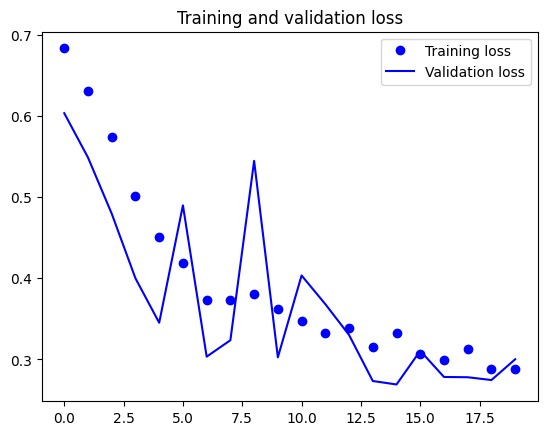

In [ ]:
model, history = run_model(model, "Conv2D512Filters_TwoDropouts0-3", train_ds, val_ds, 50, patience=5, monitor='val_loss')
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, test_ds)

34/34 [==============================] - 6s 175ms/step
Classification report:
              precision    recall  f1-score   support

         all     0.9100    0.9610    0.9348      1463
         hem     0.9031    0.7925    0.8442       670

    accuracy                         0.9081      2133
   macro avg     0.9065    0.8768    0.8895      2133
weighted avg     0.9078    0.9081    0.9064      2133



34/34 [==============================] - 4s 128ms/step


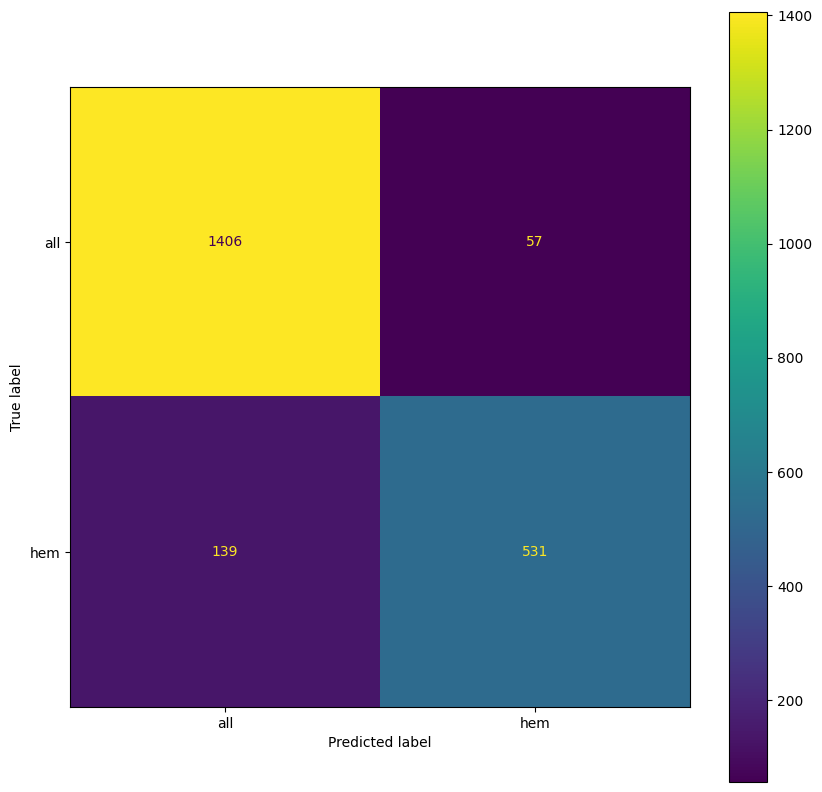

In [ ]:
plot_confusionmatrix(model, test_ds)

# One Dense layer with 512 neurons, Two Dropouts with 0.3, Additional layer
Now, let's define the model that we intend to train.

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

x = data_augmentation_layers(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=3)(x)
x = layers.Conv2D(filters=512, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=3)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation='relu', name='hidden_classifier')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model = compile_model(model, loss="binary_crossentropy")
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_27 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 112, 112, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_28 (Conv2D)          (None, 112, 112, 64)      18496     
                                                           

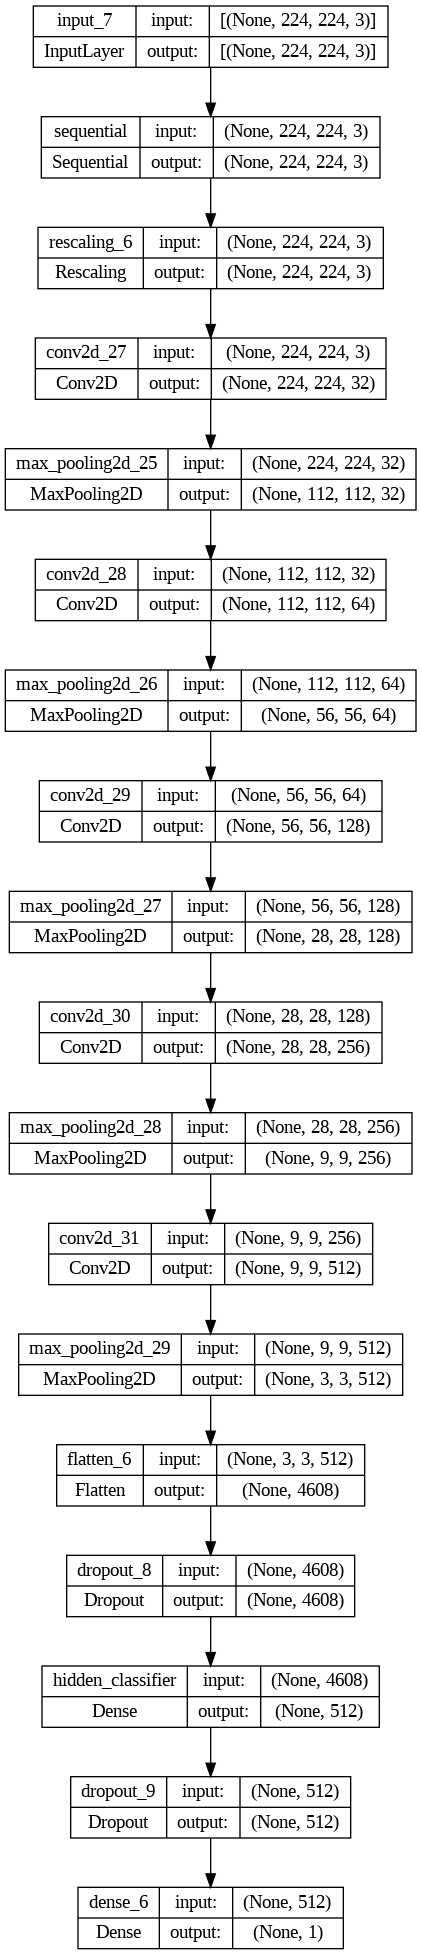

In [ ]:
plot_model(model, show_shapes = True)

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.6838 - accuracy: 0.5525
Epoch 1: val_loss improved from inf to 0.78006, saving model to /content/model/Dense512Neurons_TwoDropouts0-3_AdditionalLayer.h5
100/100 [==============================] - 26s 226ms/step - loss: 0.6838 - accuracy: 0.5525 - val_loss: 0.7801 - val_accuracy: 0.4165


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 0.6017 - accuracy: 0.6800
Epoch 2: val_loss improved from 0.78006 to 0.51268, saving model to /content/model/Dense512Neurons_TwoDropouts0-3_AdditionalLayer.h5
100/100 [==============================] - 21s 199ms/step - loss: 0.6017 - accuracy: 0.6800 - val_loss: 0.5127 - val_accuracy: 0.7763
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.5514 - accuracy: 0.7275
Epoch 3: val_loss improved from 0.51268 to 0.44403, saving model to /content/model/Dense512Neurons_TwoDropouts0-3_AdditionalLayer.h5
100/100 [==============================] - 20s 193ms/step - loss: 0.5514 - accuracy: 0.7275 - val_loss: 0.4440 - val_accuracy: 0.8053
Epoch 4/50
100/100 [==============================] - ETA: 0s - loss: 0.5117 - accuracy: 0.7448
Epoch 4: val_loss did not improve from 0.44403
100/100 [==============================] - 19s 179ms/step - loss: 0.5117 - accuracy: 0.7448 - val_loss: 0.4728 - val_accuracy: 0.78

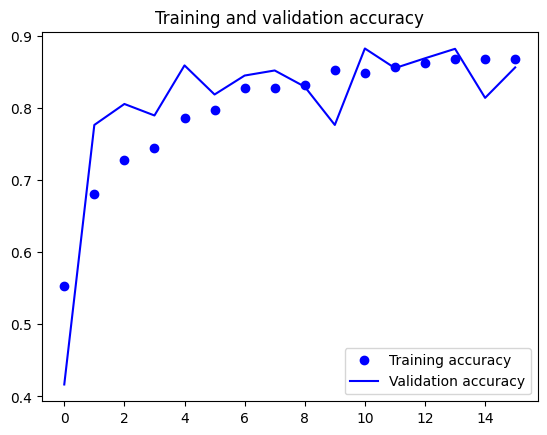

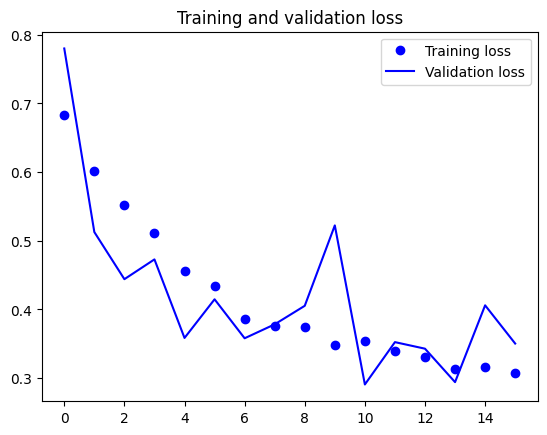

In [ ]:
model, history = run_model(model, "Dense512Neurons_TwoDropouts0-3_AdditionalLayer", train_ds, val_ds, 50, patience=5, monitor='val_loss')
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, test_ds)

34/34 [==============================] - 4s 114ms/step
Classification report:
              precision    recall  f1-score   support

         all     0.8899    0.9672    0.9270      1463
         hem     0.9116    0.7388    0.8162       670

    accuracy                         0.8955      2133
   macro avg     0.9008    0.8530    0.8716      2133
weighted avg     0.8967    0.8955    0.8922      2133



34/34 [==============================] - 4s 115ms/step


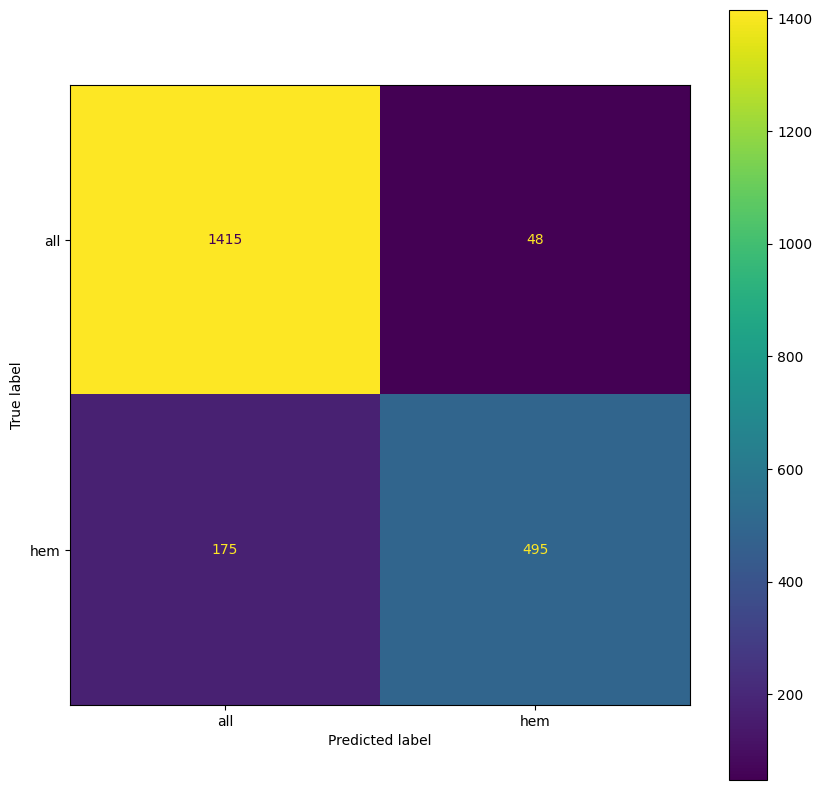

In [ ]:
plot_confusionmatrix(model, test_ds)

# Two Dense layer with 512 neurons, Two Dropouts with 0.3, Additional layer
Now, let's define the model that we intend to train.

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

x = data_augmentation_layers(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=3)(x)
x = layers.Conv2D(filters=512, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=3)(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu', name='hidden_classifier0')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation='relu', name='hidden_classifier1')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model = compile_model(model, loss="binary_crossentropy")
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling_7 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_32 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 112, 112, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_33 (Conv2D)          (None, 112, 112, 64)      18496     
                                                           

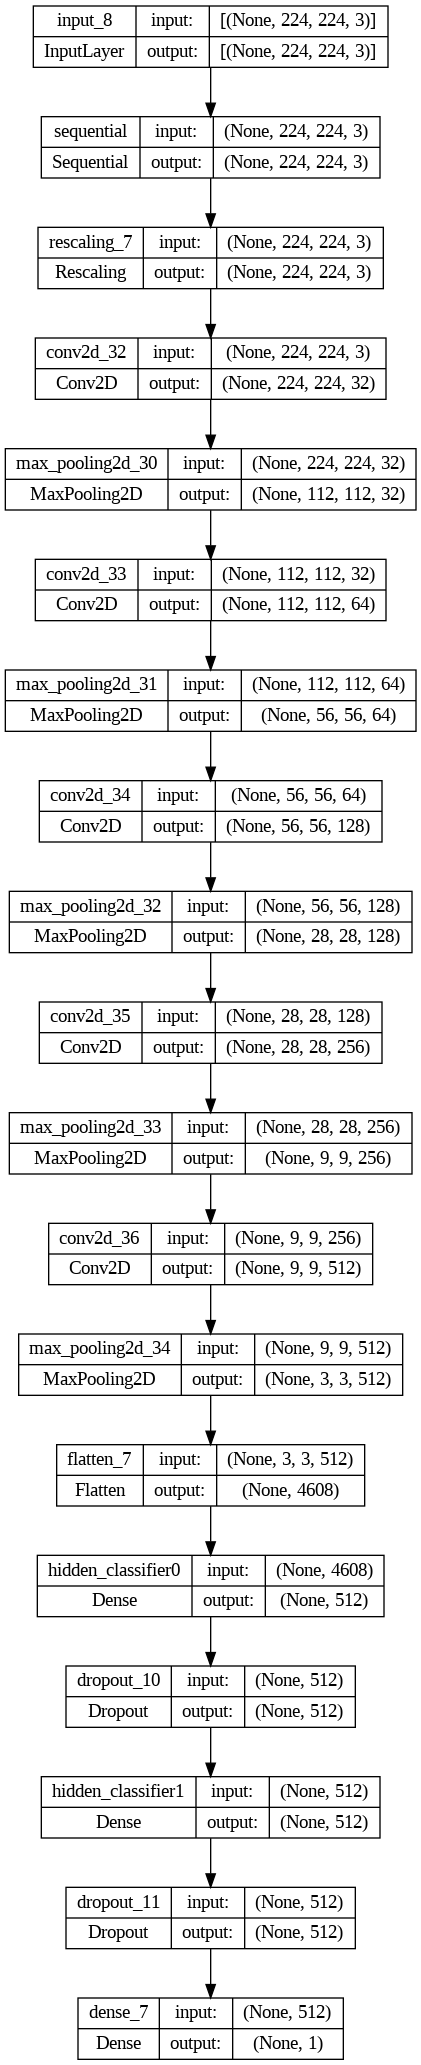

In [ ]:
plot_model(model, show_shapes = True)

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.6844 - accuracy: 0.5532
Epoch 1: val_loss improved from inf to 0.60948, saving model to /content/model/TwoDense512Neurons_TwoDropouts0-3_AdditionalLayer.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 26s 218ms/step - loss: 0.6844 - accuracy: 0.5532 - val_loss: 0.6095 - val_accuracy: 0.6876
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 0.6116 - accuracy: 0.6762
Epoch 2: val_loss did not improve from 0.60948
100/100 [==============================] - 19s 180ms/step - loss: 0.6116 - accuracy: 0.6762 - val_loss: 0.6290 - val_accuracy: 0.6693
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.5651 - accuracy: 0.7093
Epoch 3: val_loss improved from 0.60948 to 0.59362, saving model to /content/model/TwoDense512Neurons_TwoDropouts0-3_AdditionalLayer.h5
100/100 [==============================] - 20s 194ms/step - loss: 0.5651 - accuracy: 0.7093 - val_loss: 0.5936 - val_accuracy: 0.7190
Epoch 4/50
100/100 [==============================] - ETA: 0s - loss: 0.5294 - accuracy: 0.7392
Epoch 4: val_loss improved from 0.59362 to 0.50625, saving model to /content/model/TwoDense512Neurons_TwoDropouts0-3_Additional

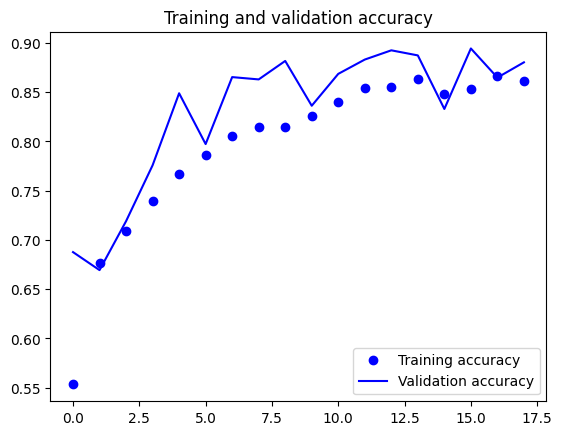

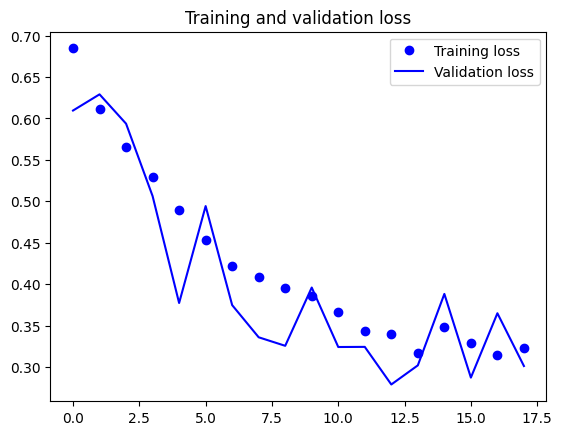

In [ ]:
model, history = run_model(model, "TwoDense512Neurons_TwoDropouts0-3_AdditionalLayer", train_ds, val_ds, 50, patience=5, monitor='val_loss')
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, test_ds)

34/34 [==============================] - 4s 111ms/step
Classification report:
              precision    recall  f1-score   support

         all     0.9063    0.9590    0.9319      1463
         hem     0.8974    0.7836    0.8367       670

    accuracy                         0.9039      2133
   macro avg     0.9019    0.8713    0.8843      2133
weighted avg     0.9035    0.9039    0.9020      2133



34/34 [==============================] - 5s 150ms/step


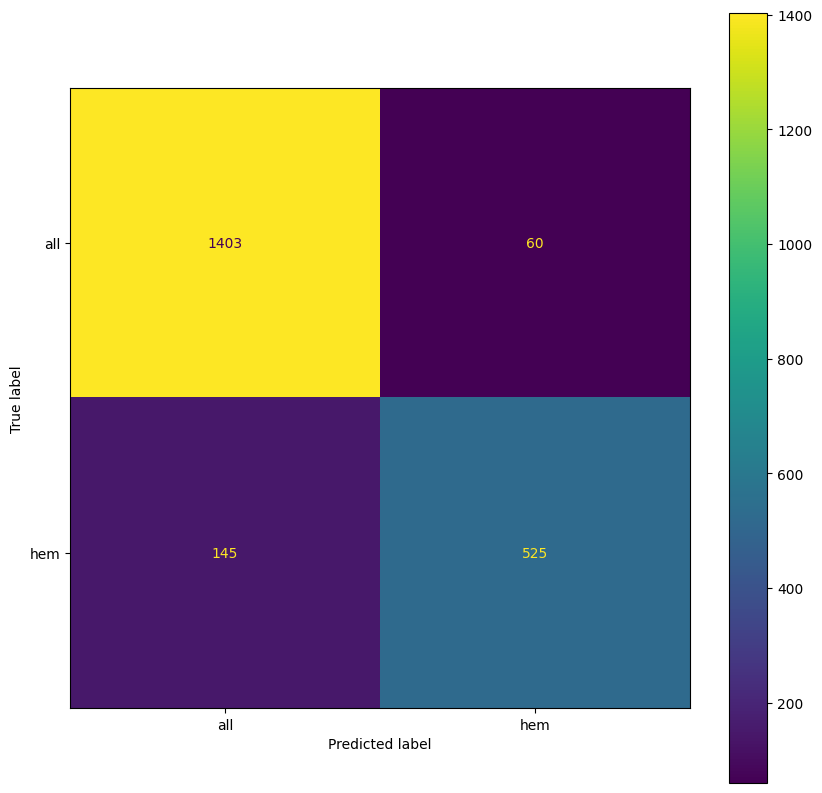

In [ ]:
plot_confusionmatrix(model, test_ds)